In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import psycopg2
from psycopg2 import extras
from pandas import DataFrame

## Задание 1

In [55]:
# Импортируем данные из датасета
df = pd.read_csv('exam_1.csv', sep = ';')

In [56]:
df

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94
5,131876.90,99814.71,362861.36,New York,156991.12
6,134615.46,147198.87,127716.82,California,156122.51
7,130298.13,145530.06,323876.68,Florida,155752.60
8,120542.52,148718.95,311613.29,New York,152211.77
9,123334.88,108679.17,304981.62,California,149759.96


## Data Preprocessing

In [57]:
# Let's check how much the data are spread out from the mean.
mean_rd_spend = np.mean(df['R&D Spend'], axis=0)
sd_rd_spend = np.std(df['R&D Spend'], axis=0)

mean_Administration = np.mean(df['Administration'], axis=0)
sd_Administration = np.std(df['Administration'], axis=0)

mean_Marketing_Spend = np.mean(df['Marketing Spend'], axis=0)
sd_Marketing_Spend = np.std(df['Marketing Spend'], axis=0)

mean_Profit= np.mean(df['Profit'], axis=0)
sd_Profit = np.std(df['Profit'], axis=0)

counter_rd_spend = 0
counter_Administration = 0
counter_Marketing_Spend = 0
counter_mean_Profit = 0
                                     

for rd_spend, Administration, Marketing_Spend, Profit in zip(df['R&D Spend'], df['Administration'], df['Marketing Spend'], df['Profit']):
        if not mean_rd_spend - 3*sd_rd_spend <= rd_spend <= mean_rd_spend + 3*sd_rd_spend:
            counter_rd_spend += 1
        if not mean_Administration - 3*sd_Administration <= Administration <= mean_Administration + 3*sd_Administration:
            counter_Administration += 1
            
        if not mean_Marketing_Spend - 3*sd_Marketing_Spend <= Marketing_Spend <= mean_Marketing_Spend + 3*sd_Marketing_Spend:
            counter_Marketing_Spend += 1                                                                  
        if not mean_Profit - 3*sd_Profit <= Profit <= mean_Profit + 3*sd_Profit:
            counter_mean_Profit += 1                                                           

counter_dicts = {'counter_rd_spend': counter_rd_spend,
                'counter_Administration': counter_Administration,
                'counter_Marketing_Spend': counter_Marketing_Spend,

                'counter_mean_Profit': counter_mean_Profit
                }
print(counter_dicts)

{'counter_rd_spend': 0, 'counter_Administration': 0, 'counter_Marketing_Spend': 0, 'counter_mean_Profit': 0}


Как мы видим, данные не имеют значения вне 3 сигм, соответственно, не требуют дополнительной обработки.

Переменная State является факторной, т.е. нам нужно преобразовать ее значения к 0,1..

In [58]:
# Function Encoding
def encoding_char(x):
    char_var = list(set(x.columns) - set(x._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(x[col_names])
        x[col_names] = pd.factorize(x[col_names])[0]
    return(x)


# Encoding categorical data
df = encoding_char(df)
df

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,0,192261.83
1,162597.70,151377.59,443898.53,1,191792.06
2,153441.51,101145.55,407934.54,2,191050.39
3,144372.41,118671.85,383199.62,0,182901.99
4,142107.34,91391.77,366168.42,2,166187.94
5,131876.90,99814.71,362861.36,0,156991.12
6,134615.46,147198.87,127716.82,1,156122.51
7,130298.13,145530.06,323876.68,2,155752.60
8,120542.52,148718.95,311613.29,0,152211.77
9,123334.88,108679.17,304981.62,1,149759.96


<AxesSubplot:ylabel='Frequency'>

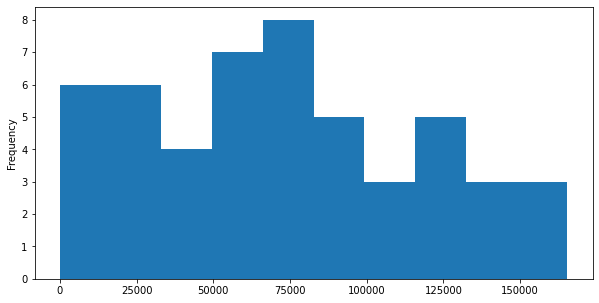

In [59]:
df['R&D Spend'].plot(kind = 'hist', figsize=(10,5))

<AxesSubplot:ylabel='Frequency'>

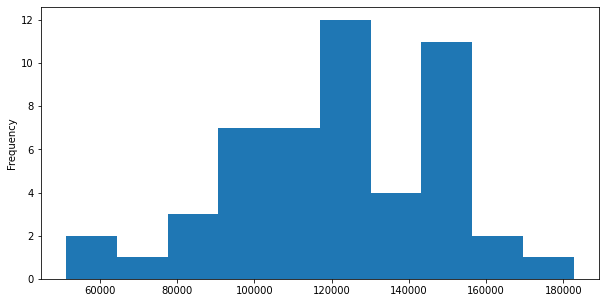

In [60]:
df['Administration'].plot(kind = 'hist', figsize=(10,5))

<AxesSubplot:ylabel='Frequency'>

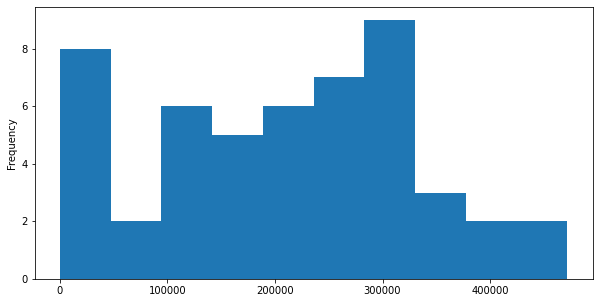

In [61]:
df['Marketing Spend'].plot(kind = 'hist', figsize=(10,5))

<AxesSubplot:ylabel='Frequency'>

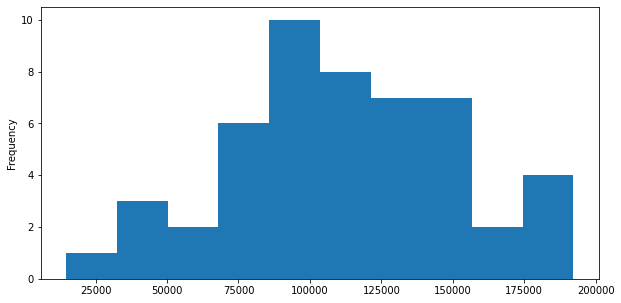

In [62]:
df['Profit'].plot(kind = 'hist', figsize=(10,5))

Наши данные можно назвать весьма симметричными, поэтому не будем заниматься процедурой логарифмирования.

In [63]:
df.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

## Simple Linear Regression

Для начала проверим корреляцию между переменными для того, чтобы отобрать фактор для модели.

In [64]:
# Cheking correlations
correlation = df.corr()
correlation.style.background_gradient(cmap='coolwarm')

,R&D Spend,Administration,Marketing Spend,State,Profit
R&D Spend,1.000000,0.241955,0.724248,0.037930,0.972900
Administration,0.241955,1.000000,-0.032154,0.003026,0.200717
Marketing Spend,0.724248,-0.032154,1.000000,0.137777,0.747766
State,0.037930,0.003026,0.137777,1.000000,0.048471
Profit,0.972900,0.200717,0.747766,0.048471,1.000000


Для построение однофакторной модели имеет смысл брать R&D Spend. Также можно посмотреть на результаты модели с Marketing Spend.

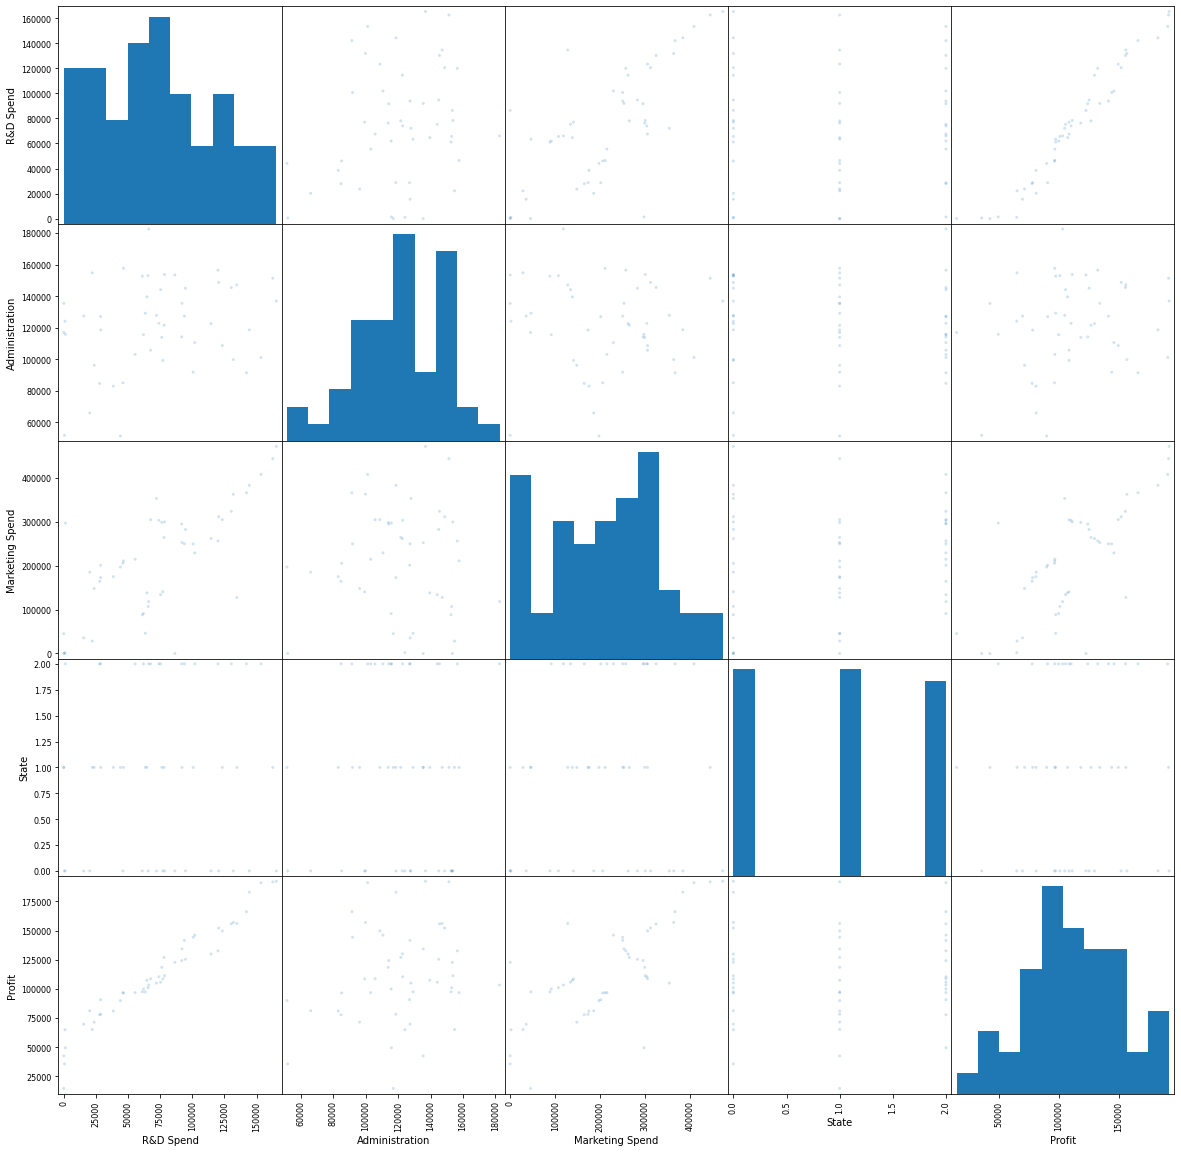

In [65]:
scatter_matrix(df, alpha=0.2, figsize=(20, 20))
plt.show()

Построим линейную регрессию с R&D Spend в качестве Х и Profit в качестве Y.

In [66]:
# Splitting the dataset into the Training set and Test set
X = df.iloc[:, 0:3].values
y = df.iloc[:, 4].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [67]:
# Fitting Simple Linear Regression to the Training set (R&D Spend)
from sklearn.linear_model import LinearRegression
sr = LinearRegression().fit(X_train[:, 0:1], y_train)

In [68]:
# Getting parameters
sr.coef_, sr.intercept_

(array([0.8516228]), 48416.297661385026)

In [69]:
# Predicting the Test set results
y_pred = sr.predict(X_test[:, 0:1])

In [70]:
# Coefficient of determination R^2
sr.score(X_train[:, 0:1], y_train), sr.score(X_test[:, 0:1], y_test)

(0.9449589778363044, 0.9464587607787219)

In [71]:
# Mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, sr.predict(X_train[:, 0:1])), mean_squared_error(y_test, y_pred)

(90128072.57027796, 68473440.71905932)

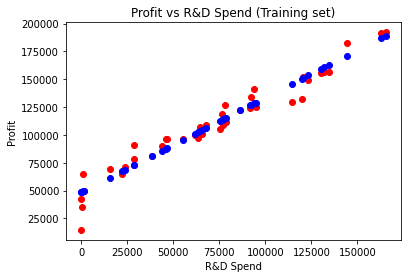

In [72]:
# Visualising the Training set results
plt.scatter(X_train[:,0], y_train, color = 'red')
plt.plot(X_train[:,0], sr.predict(X_train[:, 0:1]), 'bo')
plt.title('Profit vs R&D Spend (Training set)')
plt.xlabel('R&D Spend')
plt.ylabel('Profit')
plt.show()

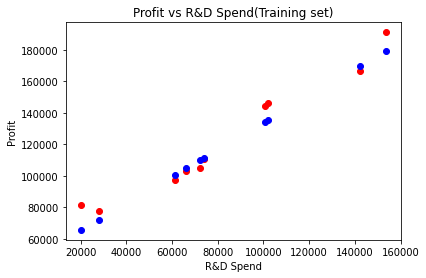

In [73]:
# Visualising the Test set results
plt.scatter(X_test[:,0], y_test, color = 'red')
plt.plot(X_test[:,0], sr.predict(X_test[:, 0:1]), 'bo')
plt.title('Profit vs R&D Spend(Training set)')
plt.xlabel('R&D Spend')
plt.ylabel('Profit')
plt.show()

Исходя из результатов коэф. детерминации, можно сделать вывод, что построенная модель отличного качества.

Построим линейную регрессию с Marketing Spend в качестве Х и Profit в качестве Y.

In [74]:
# Fitting Simple Linear Regression to the Training set (R&D Spend)
from sklearn.linear_model import LinearRegression
sr2 = LinearRegression().fit(X_train[:, 2:3], y_train)

In [75]:
# Getting parameters
sr2.coef_, sr2.intercept_

(array([0.24606293]), 59707.03350741453)

In [76]:
# Predicting the Test set results
y_pred = sr2.predict(X_test[:, 2:3])

In [77]:
# Coefficient of determination R^2
sr2.score(X_train[:, 2:3], y_train), sr2.score(X_test[:, 2:3], y_test)

(0.5636026973161414, 0.49039262125463223)

In [78]:
# Mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, sr2.predict(X_train[:, 2:3])), mean_squared_error(y_test, y_pred)

(714587887.7174464, 651732592.4097881)

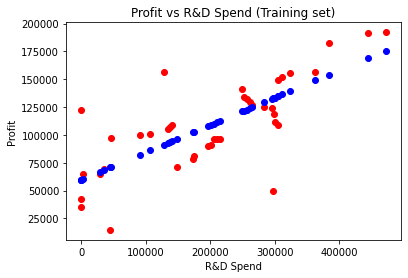

In [79]:
# Visualising the Training set results
plt.scatter(X_train[:,2], y_train, color = 'red')
plt.plot(X_train[:,2], sr2.predict(X_train[:, 2:3]), 'bo')
plt.title('Profit vs R&D Spend (Training set)')
plt.xlabel('R&D Spend')
plt.ylabel('Profit')
plt.show()

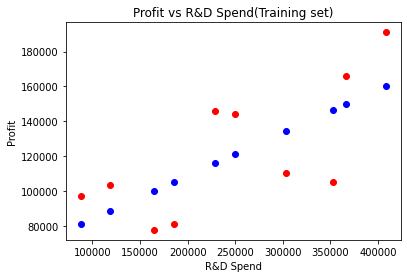

In [80]:
# Visualising the Test set results
plt.scatter(X_test[:,2], y_test, color = 'red')
plt.plot(X_test[:,2], sr2.predict(X_test[:, 2:3]), 'bo')
plt.title('Profit vs R&D Spend(Training set)')
plt.xlabel('R&D Spend')
plt.ylabel('Profit')
plt.show()

Исходя из результатов коэф. детерминации, можно сделать вывод, что построенная модель значительно уступает той, что была построена на основе R&D Spend в качестве переменной Х. Именно ее стоит рассматривать, как пригодную для прогнозирования модель.

### ВЫВОД: для однофакторной модели (R&D Spend): R^2 = 0.94, для однофакторной модели (Marketing Spend): R^2 = 0.56. Первая модель значительно превосходит в качестве.


## Задание 2

## KNN

In [81]:
# Импортируем данные из датасета
df2 = pd.read_csv('exam_2.csv', sep = ';')

In [82]:
df2

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


## Data Preprocessing

In [83]:
df2 = df2.iloc[:, 1:]
df2

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0
...,...,...,...,...
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0


Избавимся от выбросов в наших данных

In [84]:
# Function Outliers
def outliers(df):
    num_var = list(df._get_numeric_data().columns)
    for col_names in num_var:
        df[col_names] = df[col_names].apply(lambda y: df[col_names].mean()-3*df[col_names].std() 
                            if y < df[col_names].mean()-3*df[col_names].std() else y)
        df[col_names] = df[col_names].apply(lambda y: df[col_names].mean()+3*df[col_names].std() 
                            if y > df[col_names].mean()+3*df[col_names].std() else y)
    return(df)


# Outliers
df2 = outliers(df2)
df2.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


Преобразуем факторную переменную Gender 

In [85]:
# Function Encoding
def encoding_char(x):
    char_var = list(set(x.columns) - set(x._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(x[col_names])
        x[col_names] = pd.factorize(x[col_names])[0]
    return(x)


# Encoding categorical data
df2 = encoding_char(df2)
df2

,Gender,Age,EstimatedSalary,Purchased
0,0,19,19000,0
1,0,35,20000,0
2,1,26,43000,0
3,1,27,57000,0
4,0,19,76000,0
...,...,...,...,...
395,1,46,41000,1
396,0,51,23000,1
397,1,50,20000,1
398,0,36,33000,0


Построим графики переменных для того, чтобы увидеть их расспределение.

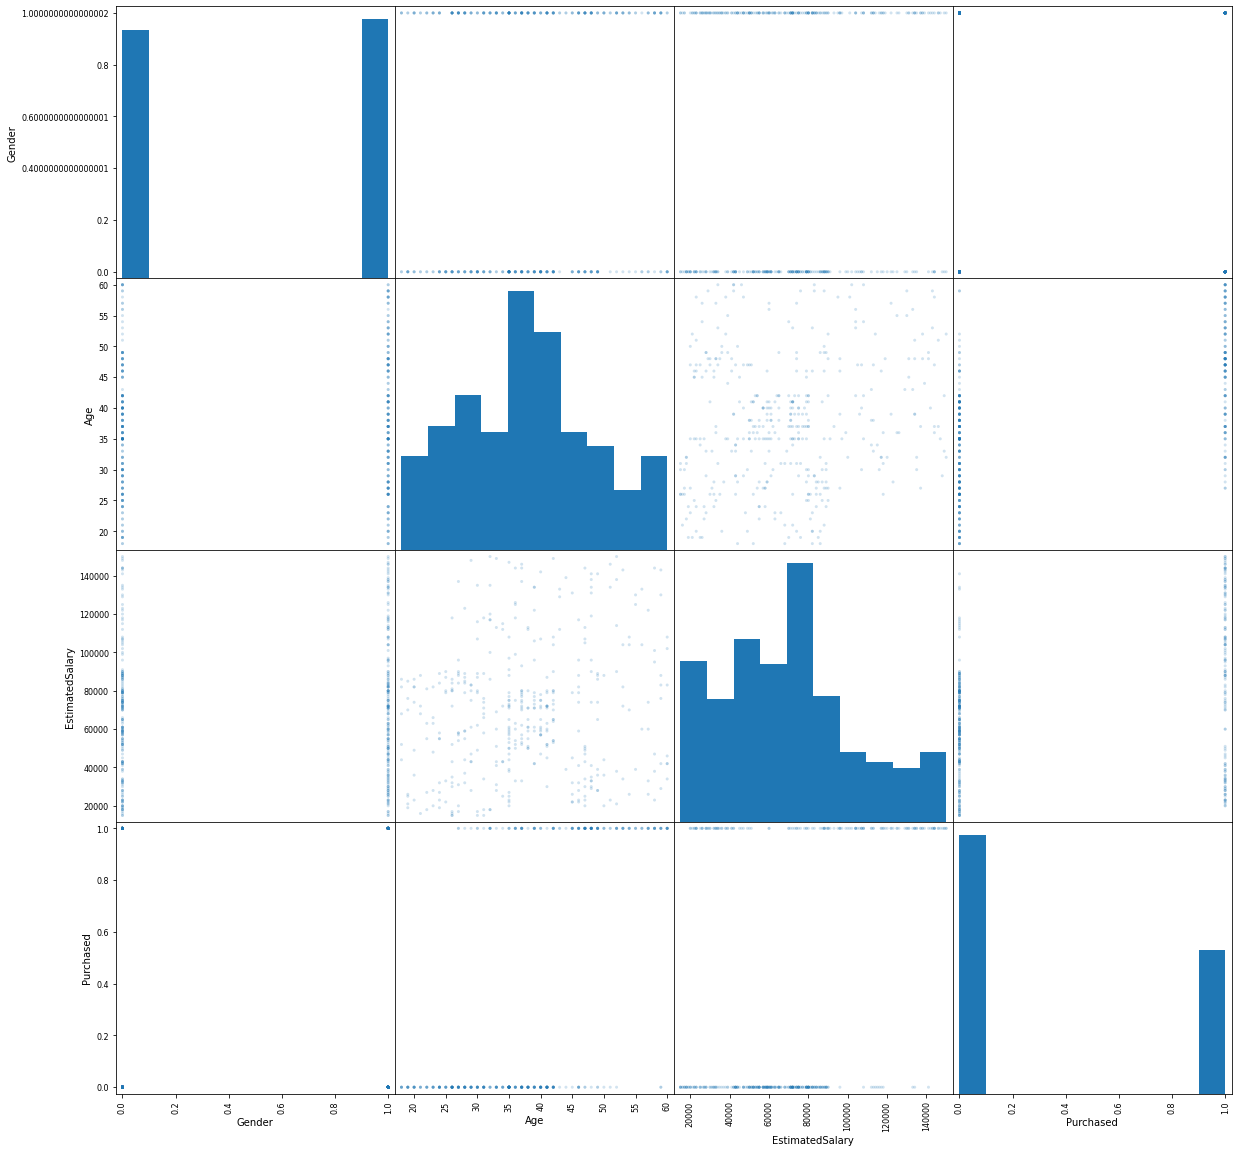

In [86]:
scatter_matrix(df2, alpha=0.2, figsize=(20, 20))
plt.show()

Наши данные можно назвать весьма симметричными, поэтому не будем заниматься процедурой логарифмирования

In [87]:
df2

,Gender,Age,EstimatedSalary,Purchased
0,0,19,19000,0
1,0,35,20000,0
2,1,26,43000,0
3,1,27,57000,0
4,0,19,76000,0
...,...,...,...,...
395,1,46,41000,1
396,0,51,23000,1
397,1,50,20000,1
398,0,36,33000,0


## K-Nearest Neighbors (K-NN)

Приступаем к построении модели, мы будем предсказывать покупку (Purchased)

In [90]:
# Splitting the dataset into the Training set and Test set
X = df2.iloc[:, :-1].values
y = df2.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Для данной модели очень важно подобрать оптимальное значение k

Minimum error:- 0.1125 at K = 10


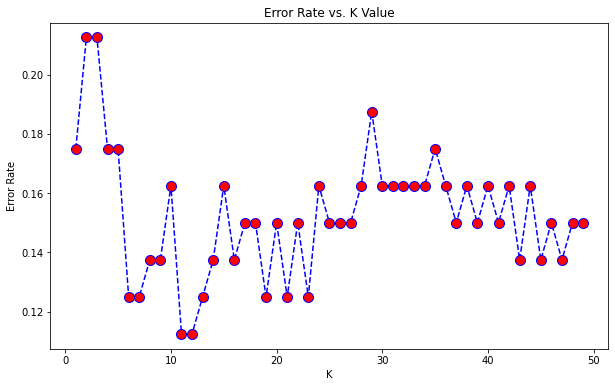

In [92]:
# Optimal K 
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1,50):
     knn = KNeighborsClassifier(n_neighbors=i)
     knn.fit(X_train,y_train)
     pred_i = knn.predict(X_test)
     error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Выберем k = 10

In [94]:
# Построим модели KNN для всех переменных.
knn = KNeighborsClassifier(n_neighbors = 12, metric = 'minkowski', p = 2).fit(X_train, y_train)

In [95]:
# Predicting the Test set results
y_pred = knn.predict(X_test)
knn.score(X_test,y_test)

0.8875

Как мы видим точность данной модели достаточно высока (0,89), т.е. ее можно использовать в прогнозах.

In [96]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[56  2]
 [ 7 15]]


Как результат, мы получили всего 9 неверных результатов исходя из нашей матрицы Confusion Matrix.

### ВЫВОД: построенная на основе всех 3 переменных модель KNN показала отличнй результат.Показатель ее точности равен практически 89%, также мы имеем всего 9 неверных результатов (7-ложно положительных и 2 ложно отрицательных)